## Feature Selection (RF importance, Chi2, RFE)

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

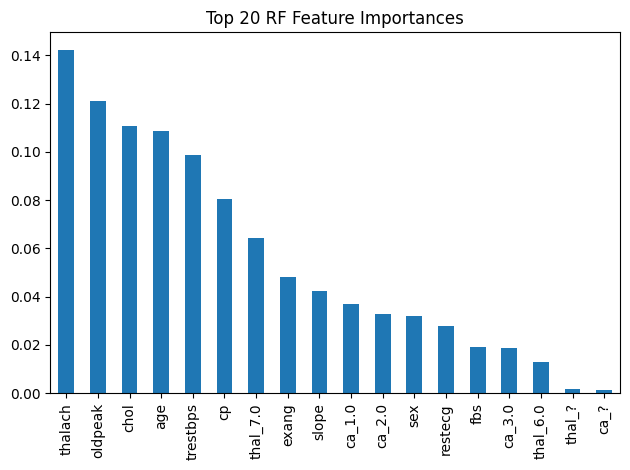

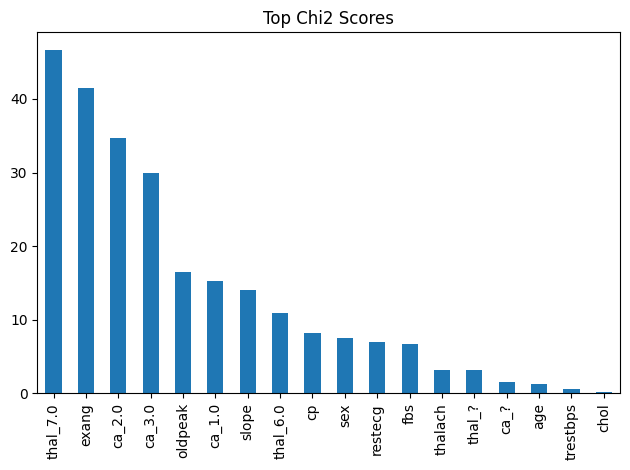

Selected features: ['oldpeak', 'thal_7.0', 'ca_2.0', 'thalach', 'cp', 'exang', 'ca_1.0', 'ca_3.0', 'slope', 'age']
Saved selected_features.csv and feature_ranking.csv


In [2]:
cleaned = pd.read_csv('../data/cleaned_heart.csv')
y = cleaned['target']
X = cleaned.drop(columns=['target'])

# --- RandomForest feature importances
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure()
importances.head(20).plot(kind='bar')
plt.title("Top 20 RF Feature Importances"); plt.tight_layout(); plt.show()

# --- Chi2 (needs non-negative)
scaler = MinMaxScaler()  # scale to [0,1] for chi2
X_nonneg = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
k = min(10, X.shape[1])  # select up to 10 features (adjust if needed)
chi2_selector = SelectKBest(score_func=chi2, k=k)
chi2_selector.fit(X_nonneg, y)
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False)

plt.figure()
chi2_scores.head(20).plot(kind='bar')
plt.title("Top Chi2 Scores"); plt.tight_layout(); plt.show()

# --- RFE with Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=None)
rfe = RFE(lr, n_features_to_select=k)
rfe.fit(X, y)
rfe_support = pd.Series(rfe.support_, index=X.columns)
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)

# Combine rankings
rank_df = pd.DataFrame({
    "rf_rank": importances.rank(ascending=False, method='dense'),
    "chi2_rank": chi2_scores.rank(ascending=False, method='dense'),
    "rfe_rank": rfe_ranking
})
rank_df["avg_rank"] = rank_df.mean(axis=1)
selected = rank_df.sort_values("avg_rank").head(k).index.tolist()
print("Selected features:", selected)

# Save reduced dataset
X_sel = X[selected]
reduced = pd.concat([X_sel, y], axis=1)
reduced.to_csv('../data/selected_features.csv', index=False)
Path("../results").mkdir(parents=True, exist_ok=True)
rank_df.sort_values('avg_rank').to_csv('../results/feature_ranking.csv')
print("Saved selected_features.csv and feature_ranking.csv")